# Data and main parameters

In [1]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
# !git clone https://github.com/lqwic/deep_var.git
# %cd deep_var/

In [3]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = crypto

# Test Model

In [4]:
class TempVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(TempVAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(input_size, hidden_size, latent_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        h_z = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        h_r = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        z_prev = torch.zeros(batch_size, seq_length + 1, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, seq_length + 1, self.input_size).to(x.device)

        z_list = []
        r_list = []

        for t in range(seq_length):
            z, h_z = self.encoder(x, z_prev[:, t, :], h_z)
            z_list.append(z)
            z_prev[:, t+1, :] = z

            z, r, h_z, h_r = self.decoder(z_prev[:, t+1, :], r_prev[:, t, :], h_z, h_r)
            r_list.append(r)
            r_prev[:, t+1, :] = r

        z_list = torch.stack(z_list, dim=1)
        r_list = torch.stack(r_list, dim=1)

        return z_list, r_list

In [168]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.input_size = input_size

        self.z_rnn = nn.GRU(input_size=latent_size, hidden_size=hidden_size, batch_first=True)
        self.z_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * latent_size),
        )
        self.r_rnn = nn.GRU(input_size=latent_size, hidden_size=hidden_size, batch_first=True)
        self.r_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * input_size),
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def reparametrization_trick(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, z_prev, r_prev, h_z_prev, h_r_prev):
        print(z_prev.shape, r_prev.shape, h_z_prev.shape, h_r_prev.shape)
        output_z, h_z = self.z_rnn(z_prev.unsqueeze(1), h_z_prev)
        print(output_z.shape, h_z.shape)
        mu_z, log_sigma_z = torch.chunk(self.z_mlp(output_z.squeeze(0)), 2, dim=-1)
        print(mu_z.shape, log_sigma_z.shape)
        z = self.reparametrization_trick(mu_z, log_sigma_z)
        print(z.shape, h_r_prev.shape)

        output_r, h_r = self.r_rnn(z, h_r_prev)
        print(h_r.shape, output_r.shape, output_r.squeeze(1).shape)
        mu_r, log_sigma_r = torch.chunk(self.r_mlp(output_r.squeeze(1)), 2, dim=-1)
        print(mu_r.shape, log_sigma_r.shape)
        r = self.reparametrization_trick(mu_r, log_sigma_r)
        print(z.squeeze(1).shape, r.shape, h_z.shape, h_r.shape)

        return z.squeeze(1), r, h_z, h_r

In [169]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TempVAE(13, 16, 10).to(device)

h_z = torch.zeros(1, 256, 16).to(device)
h_r = torch.zeros(1, 256, 16).to(device)
z_prev = torch.zeros(256, 21, 10).to(device)
r_prev = torch.zeros(256, 21, 13).to(device)
print(model.decoder(z_prev[:,1,:], r_prev[:,0,:], h_z, h_r))
# print(model(r_prev))

torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 10]) torch.Size([256, 1, 10])
torch.Size([256, 1, 10]) torch.Size([1, 256, 16])
torch.Size([1, 256, 16]) torch.Size([256, 1, 16]) torch.Size([256, 16])
torch.Size([256, 13]) torch.Size([256, 13])
torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
(tensor([[-1.1002,  1.4087, -0.4914,  ..., -0.4243, -0.0170, -1.6368],
        [ 0.4582, -0.1532, -0.3940,  ..., -0.5853, -0.3948,  0.2706],
        [ 0.3319, -0.7072,  2.6056,  ..., -1.4053, -1.7013, -0.0805],
        ...,
        [ 2.0992,  1.5470,  2.9228,  ..., -1.3042, -0.0998, -0.8956],
        [ 0.0916, -0.9790,  2.4890,  ..., -0.6687, -1.4711,  1.1999],
        [ 1.2060, -1.2229,  2.1090,  ..., -1.5005, -0.8332, -0.5133]],
       grad_fn=<SqueezeBackward1>), tensor([[ 1.2152, -0.0167, -0.0690,  ...,  0.9727,  0.3108, -2.1280],
     

torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])

torch.Size([256, 1, 16]) torch.Size([1, 256, 16])

torch.Size([256, 1, 10]) torch.Size([256, 1, 10])

torch.Size([256, 1, 10]) torch.Size([1, 256, 16])

torch.Size([1, 256, 16]) torch.Size([256, 1, 16])

torch.Size([256, 1, 13]) torch.Size([256, 1, 13])

torch.Size([256, 1, 13])

torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])

torch.Size([1, 256, 16])

torch.Size([256, 10]) torch.Size([256, 10])

torch.Size([256, 10]) torch.Size([1, 256, 16])

torch.Size([1, 256, 16])

torch.Size([256, 13]) torch.Size([256, 13])

torch.Size([256, 13])

In [170]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.latent_size = latent_size

        self.left_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.right_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.z_rnn = nn.GRU(input_size=2 * hidden_size + latent_size, hidden_size=hidden_size, batch_first=True)
        self.z_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * latent_size),
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def reparametrization_trick(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, r, z_prev, h_z_prev):
        print(r.shape, z_prev.shape, h_z_prev.shape)
        _, h_left = self.left_rnn(r)
        _, h_right = self.right_rnn(torch.flip(r, [1]))
        print(h_left.shape, h_right.shape)

        h_concat = torch.cat([h_left.squeeze(0), h_right.squeeze(0)], dim=-1)
        h_concat = h_concat.unsqueeze(1)
        print(h_concat.shape)

        z_input = torch.cat([z_prev.unsqueeze(1), h_concat], dim=-1)
        print(z_input.shape)
        _, h_z = self.z_rnn(z_input, h_z_prev)
        print(h_z.shape)

        mu_z, log_sigma_z = torch.chunk(self.z_mlp(h_z.squeeze(1)), 2, dim=-1)
        print(mu_z.shape, log_sigma_z.shape)
        z = self.reparametrization_trick(mu_z, log_sigma_z)
        print(z.shape)

        return z, h_z

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TempVAE(13, 16, 10).to(device)

h_z = torch.zeros(1, 256, 16).to(device)
h_r = torch.zeros(1, 256, 16).to(device)
z_prev = torch.zeros(256, 21, 10).to(device)
r_prev = torch.zeros(256, 21, 13).to(device)
print(model.encoder(r_prev, z_prev[:,0,:], h_z))

torch.Size([256, 21, 13]) torch.Size([256, 10]) torch.Size([1, 256, 16])
torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 32])
torch.Size([256, 1, 42])
torch.Size([1, 256, 16])
torch.Size([1, 256, 10]) torch.Size([1, 256, 10])
torch.Size([1, 256, 10])
(tensor([[[-1.4272, -0.6653,  0.6345,  ...,  1.0936,  0.4105,  1.3922],
         [-0.5611,  1.7228,  0.2668,  ...,  0.4307, -0.1324, -0.9197],
         [ 0.1761, -0.0806,  0.3885,  ..., -1.0569,  1.0810, -0.1630],
         ...,
         [ 0.4468,  0.2130, -0.8116,  ..., -1.1058,  0.5315, -0.1227],
         [ 0.6339, -0.0345, -1.1263,  ..., -0.4185, -0.3236, -2.6386],
         [ 0.0253,  1.1101,  0.8766,  ..., -0.4753,  0.3912, -1.0067]]],
       grad_fn=<AddBackward0>), tensor([[[-0.1469, -0.1153, -0.1464,  ...,  0.1613,  0.0224, -0.0206],
         [-0.1469, -0.1153, -0.1464,  ...,  0.1613,  0.0224, -0.0206],
         [-0.1469, -0.1153, -0.1464,  ...,  0.1613,  0.0224, -0.0206],
         ...,
         [-0.1469, -0.115

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TempVAE(13, 16, 10).to(device)

h_z = torch.zeros(1, 256, 16).to(device)
h_r = torch.zeros(1, 256, 16).to(device)
z_prev = torch.zeros(256, 21, 10).to(device)
r_prev = torch.zeros(256, 21, 13).to(device)
print(model(r_prev))

torch.Size([256, 21, 13]) torch.Size([256, 10]) torch.Size([1, 256, 16])
torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 32])
torch.Size([256, 1, 42])
torch.Size([1, 256, 16])
torch.Size([1, 256, 10]) torch.Size([1, 256, 10])
torch.Size([1, 256, 10])
torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 10]) torch.Size([256, 1, 10])
torch.Size([256, 1, 10]) torch.Size([1, 256, 16])
torch.Size([1, 256, 16]) torch.Size([256, 1, 16]) torch.Size([256, 16])
torch.Size([256, 13]) torch.Size([256, 13])
torch.Size([256, 10]) torch.Size([256, 13]) torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 21, 13]) torch.Size([256, 10]) torch.Size([1, 256, 16])
torch.Size([1, 256, 16]) torch.Size([1, 256, 16])
torch.Size([256, 1, 32])
torch.Size([256, 1, 42])
torch.Size([1, 256, 16])
torch.Size([1, 256, 10]) torch.Size([1, 256, 10])
torch.Size([1, 256, 10])


# Model

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.latent_size = latent_size

        self.left_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        self.right_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        self.z_rnn = nn.GRU(input_size=2 * hidden_size + latent_size, hidden_size=hidden_size, batch_first=True)

        self.z_mu_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
        )

        self.z_log_sigma_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.Tanh(),  # Ensure positive diagonal covariance
        )

        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def reparametrization_trick(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, r, z_prev, h_z_prev):
        # r: (batch_size, seq_length, input_size)
        # z_prev: (batch_size, latent_size)
        # h_z_prev: (1, batch_size, hidden_size)

        _, h_left = self.left_rnn(r)  # h_left: (1, batch_size, hidden_size)
        h_left = self.dropout(h_left)
        _, h_right = self.right_rnn(torch.flip(r, [1]))  # h_right: (1, batch_size, hidden_size)
        h_right = self.dropout(h_right)

        h_concat = torch.cat([h_left.squeeze(0), h_right.squeeze(0)], dim=-1)  # h_concat: (batch_size, 2 * hidden_size)
        h_concat = h_concat.unsqueeze(1)  # h_concat: (batch_size, 1, 2 * hidden_size)

        z_input = torch.cat([z_prev.unsqueeze(1), h_concat], dim=-1)  # z_input: (batch_size, 1, 2 * hidden_size + latent_size)
        _, h_z = self.z_rnn(z_input, h_z_prev)  # h_z: (1, batch_size, hidden_size)
        h_z = self.dropout(h_z)

        mu_z = self.z_mu_mlp(h_z.squeeze(0))  # mu_z: (batch_size, latent_size)
        log_sigma_z = self.z_log_sigma_mlp(h_z.squeeze(0))  # log_sigma_z: (batch_size, latent_size)
        z = self.reparametrization_trick(mu_z, log_sigma_z)  # z: (batch_size, latent_size)
        return z, h_z

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.input_size = input_size
        
        self.z_rnn = nn.GRU(input_size=latent_size, hidden_size=hidden_size, batch_first=True)
        # input_size: latent_size
        # hidden_size: hidden_size
        
        self.z_mu_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # input_size: hidden_size, output_size: hidden_size
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),  # input_size: hidden_size, output_size: latent_size
        )
        
        self.z_log_sigma_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # input_size: hidden_size, output_size: hidden_size
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),  # input_size: hidden_size, output_size: latent_size
            nn.Tanh(),  # Ensure positive diagonal covariance
        )
        
        self.r_rnn = nn.GRU(input_size=latent_size + input_size, hidden_size=hidden_size, batch_first=True)
        # input_size: latent_size + input_size
        # hidden_size: hidden_size
        
        self.r_mu_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # input_size: hidden_size, output_size: hidden_size
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),  # input_size: hidden_size, output_size: input_size
        )
        
        self.r_log_sigma_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # input_size: hidden_size, output_size: hidden_size
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),  # input_size: hidden_size, output_size: input_size
            nn.Tanh(),  # Ensure positive diagonal covariance
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def reparametrization_trick(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, z_prev, r_prev, h_z_prev, h_r_prev):
        # z_prev: (batch_size, latent_size)
        # r_prev: (batch_size, input_size)
        # h_z_prev: (1, batch_size, hidden_size)
        # h_r_prev: (1, batch_size, hidden_size)
        
        _, h_z = self.z_rnn(z_prev.unsqueeze(1), h_z_prev)
        # z_prev.unsqueeze(1): (batch_size, 1, latent_size)
        # h_z: (1, batch_size, hidden_size)
        
        h_z = self.dropout(h_z)
        
        mu_z = self.z_mu_mlp(h_z.squeeze(0))  # mu_z: (batch_size, latent_size)
        log_sigma_z = self.z_log_sigma_mlp(h_z.squeeze(0))  # log_sigma_z: (batch_size, latent_size)
        z = self.reparametrization_trick(mu_z, log_sigma_z)  # z: (batch_size, latent_size)
        
        _, h_r = self.r_rnn(torch.cat([z.unsqueeze(1), r_prev.unsqueeze(1)], dim=-1), h_r_prev)
        # z.unsqueeze(1): (batch_size, 1, latent_size)
        # r_prev.unsqueeze(1): (batch_size, 1, input_size)
        # torch.cat([z.unsqueeze(1), r_prev.unsqueeze(1)], dim=-1): (batch_size, 1, latent_size + input_size)
        # h_r: (1, batch_size, hidden_size)
        
        h_r = self.dropout(h_r)
        
        mu_r = self.r_mu_mlp(h_r.squeeze(0))  # mu_r: (batch_size, input_size)
        log_sigma_r = self.r_log_sigma_mlp(h_r.squeeze(0))  # log_sigma_r: (batch_size, input_size)
        r = self.reparametrization_trick(mu_r, log_sigma_r)  # r: (batch_size, input_size)
        
        return z, r, h_z, h_r, mu_z, log_sigma_z

class TempVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.1):
        super(TempVAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = Encoder(input_size, hidden_size, latent_size, dropout_rate)
        self.decoder = Decoder(input_size, hidden_size, latent_size, dropout_rate)

    def _kl_divergence_gauss(self, mu1, log_sigma1, mu2, log_sigma2):
        sigma1, sigma2 = log_sigma1.exp(), log_sigma2.exp()
        kl = torch.log(sigma2 / sigma1) + (sigma1 ** 2 + (mu1 - mu2) ** 2) / (2 * sigma2 ** 2) - 0.5
        return torch.sum(kl)

    def calculate_loss(self, z_list, r_list, x, mu_z_list, log_sigma_z_list, beta=1.0, lambda_reg=0.01):
        recon_loss = nn.MSELoss(reduction='sum')(r_list, x)

        kl_loss = 0
        for t in range(mu_z_list.size(1)):
            mu_z, log_sigma_z = mu_z_list[:, t, :], log_sigma_z_list[:, t, :]
            mu_prior, log_sigma_prior = torch.zeros_like(mu_z), torch.zeros_like(log_sigma_z)  # Assuming standard normal prior
            kl_loss += self._kl_divergence_gauss(mu_z, log_sigma_z, mu_prior, log_sigma_prior)

        l2_reg = 0
        for m in self.modules():
            if isinstance(m, nn.Linear):
                l2_reg += torch.sum(m.weight ** 2)

        elbo_loss = recon_loss + beta * kl_loss + lambda_reg * l2_reg
        return recon_loss, kl_loss, l2_reg, elbo_loss

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        batch_size, seq_length, _ = x.size()

        h_z = torch.zeros(1, batch_size, self.hidden_size).to(x.device)  # h_z: (1, batch_size, hidden_size)
        h_r = torch.zeros(1, batch_size, self.hidden_size).to(x.device)  # h_r: (1, batch_size, hidden_size)
        z_prev = torch.zeros(batch_size, self.latent_size).to(x.device)  # z_prev: (batch_size, latent_size)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)  # r_prev: (batch_size, input_size)

        z_list = []
        r_list = []
        mu_z_list = []
        log_sigma_z_list = []

        for t in range(seq_length):
            z, h_z = self.encoder(x, z_prev, h_z)  # z: (batch_size, latent_size), h_z: (1, batch_size, hidden_size)
            z_list.append(z)
            z_prev = z

            z, r, h_z, h_r, mu_z, log_sigma_z = self.decoder(z_prev, r_prev, h_z, h_r)  # z: (batch_size, latent_size), r: (batch_size, input_size), h_z: (1, batch_size, hidden_size), h_r: (1, batch_size, hidden_size)
            r_list.append(r)
            mu_z_list.append(mu_z)
            log_sigma_z_list.append(log_sigma_z)
            r_prev = r

        z_list = torch.stack(z_list, dim=1)  # z_list: (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # r_list: (batch_size, seq_length, input_size)
        mu_z_list = torch.stack(mu_z_list, dim=1)
        log_sigma_z_list = torch.stack(log_sigma_z_list, dim=1)

        return z_list, r_list, mu_z_list, log_sigma_z_list

# Training

In [16]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data = (data - data.mean(axis=0)) / data.std(axis=0)

    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])

    sequences = torch.tensor(sequences, dtype=torch.float32)
    train_size = int(train_ratio * len(sequences))
    train_data = sequences[:train_size]
    test_data = sequences[train_size - seq_length:]

    train_dataset = TensorDataset(train_data)
    test_dataset = TensorDataset(test_data)

    return train_dataset, test_dataset


def train(model, train_loader, optimizer, beta=1.0, lambda_reg=0.01, device=torch.device('cpu')):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    train_l2_loss = 0

    for batch in train_loader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        z_list, r_list, mu_z_list, log_sigma_z_list = model(batch)
        recon_loss, kl_loss, l2_loss, loss = model.calculate_loss(
            z_list, r_list, batch, mu_z_list, log_sigma_z_list,
            beta, lambda_reg)
        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        train_l2_loss += l2_loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_kl_loss /= len(train_loader.dataset)
    train_l2_loss /= len(train_loader.dataset)

    return train_loss, train_recon_loss, train_kl_loss, train_l2_loss

def test(model, test_loader, beta=1.0, lambda_reg=0.01, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_l2_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].to(device)
            z_list, r_list, mu_z_list, log_sigma_z_list = model(batch)
            recon_loss, kl_loss, l2_loss, loss = model.calculate_loss(
                z_list, r_list, batch, mu_z_list, log_sigma_z_list,
                beta, lambda_reg
                )
            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kl_loss.item()
            test_l2_loss += l2_loss.item()

    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_kl_loss /= len(test_loader.dataset)
    test_l2_loss /= len(test_loader.dataset)

    return test_loss, test_recon_loss, test_kl_loss, test_l2_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 572.6430, Train Recon Loss: 572.6418, Train KL Loss: 386.9251, Train L2 Loss: 1.2340, Test Loss: 327.5425, Test Recon Loss: 327.5414, Test KL Loss: 411.3104, Test L2 Loss: 1.1624
Epoch [20/1000], Train Loss: 473.8371, Train Recon Loss: 473.8358, Train KL Loss: 866.0949, Train L2 Loss: 1.2369, Test Loss: 244.0902, Test Recon Loss: 244.0890, Test KL Loss: 847.9098, Test L2 Loss: 1.1656
Epoch [30/1000], Train Loss: 452.9308, Train Recon Loss: 452.9296, Train KL Loss: 1113.6155, Train L2 Loss: 1.2415, Test Loss: 233.6491, Test Recon Loss: 233.6479, Test KL Loss: 1092.7826, Test L2 Loss: 1.1698
Epoch [40/1000], Train Loss: 446.8543, Train Recon Loss: 446.8531, Train KL Loss: 1252.5353, Train L2 Loss: 1.2442, Test Loss: 232.5517, Test Recon Loss: 232.5506, Test KL Loss: 1224.0521, Test L2 Loss: 1.1723
Epoch [50/1000], Train Loss: 444.3736, Train Recon Loss: 444.3723, Train KL Loss: 1333.8016, Train L2 Loss: 1.2460, Test Loss: 230.2762, Test Recon Loss: 230.2750, 

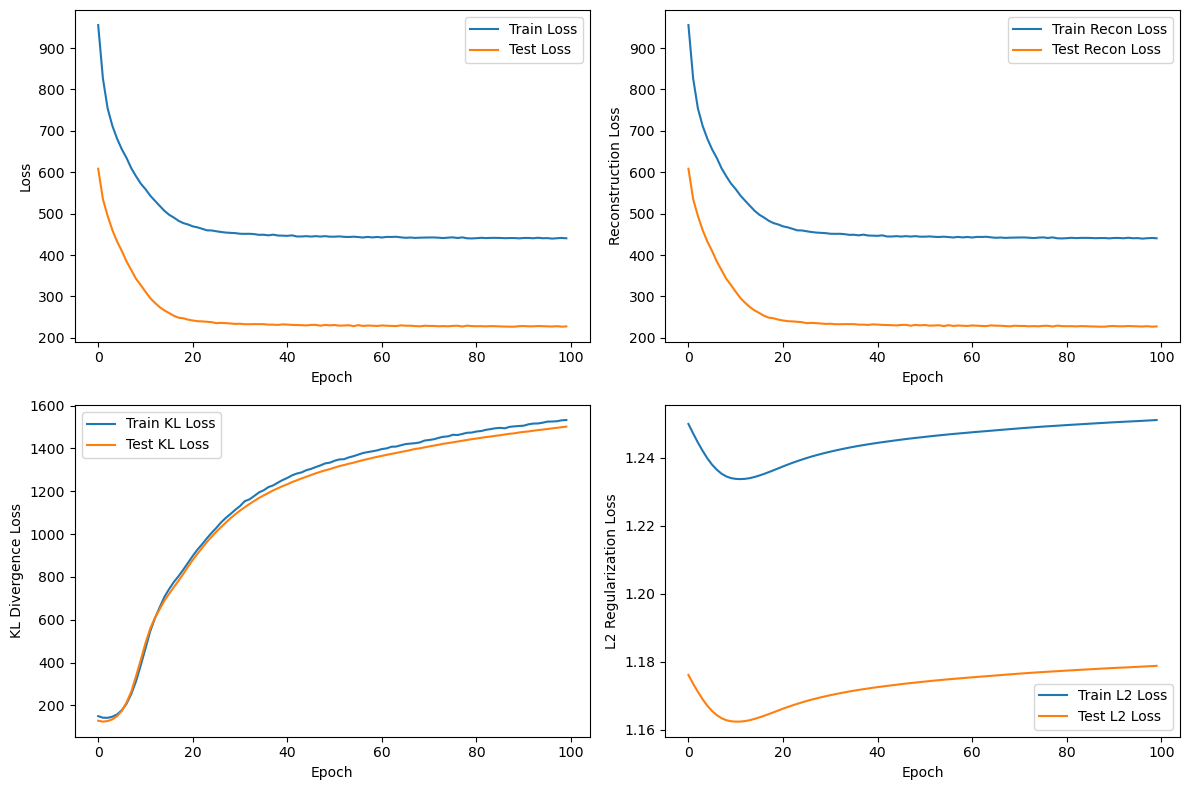

Epoch [110/1000], Train Loss: 440.2742, Train Recon Loss: 440.2729, Train KL Loss: 1552.7511, Train L2 Loss: 1.2518, Test Loss: 227.2036, Test Recon Loss: 227.2024, Test KL Loss: 1522.4540, Test L2 Loss: 1.1794
Epoch [120/1000], Train Loss: 439.7561, Train Recon Loss: 439.7548, Train KL Loss: 1573.4057, Train L2 Loss: 1.2524, Test Loss: 226.9081, Test Recon Loss: 226.9069, Test KL Loss: 1541.4329, Test L2 Loss: 1.1800
Epoch [130/1000], Train Loss: 440.7649, Train Recon Loss: 440.7636, Train KL Loss: 1590.4576, Train L2 Loss: 1.2530, Test Loss: 227.7171, Test Recon Loss: 227.7159, Test KL Loss: 1558.2081, Test L2 Loss: 1.1805
Epoch [140/1000], Train Loss: 439.0353, Train Recon Loss: 439.0341, Train KL Loss: 1608.4015, Train L2 Loss: 1.2535, Test Loss: 227.6702, Test Recon Loss: 227.6690, Test KL Loss: 1574.5650, Test L2 Loss: 1.1810
Epoch [150/1000], Train Loss: 439.5279, Train Recon Loss: 439.5266, Train KL Loss: 1621.5887, Train L2 Loss: 1.2540, Test Loss: 227.9874, Test Recon Loss: 2

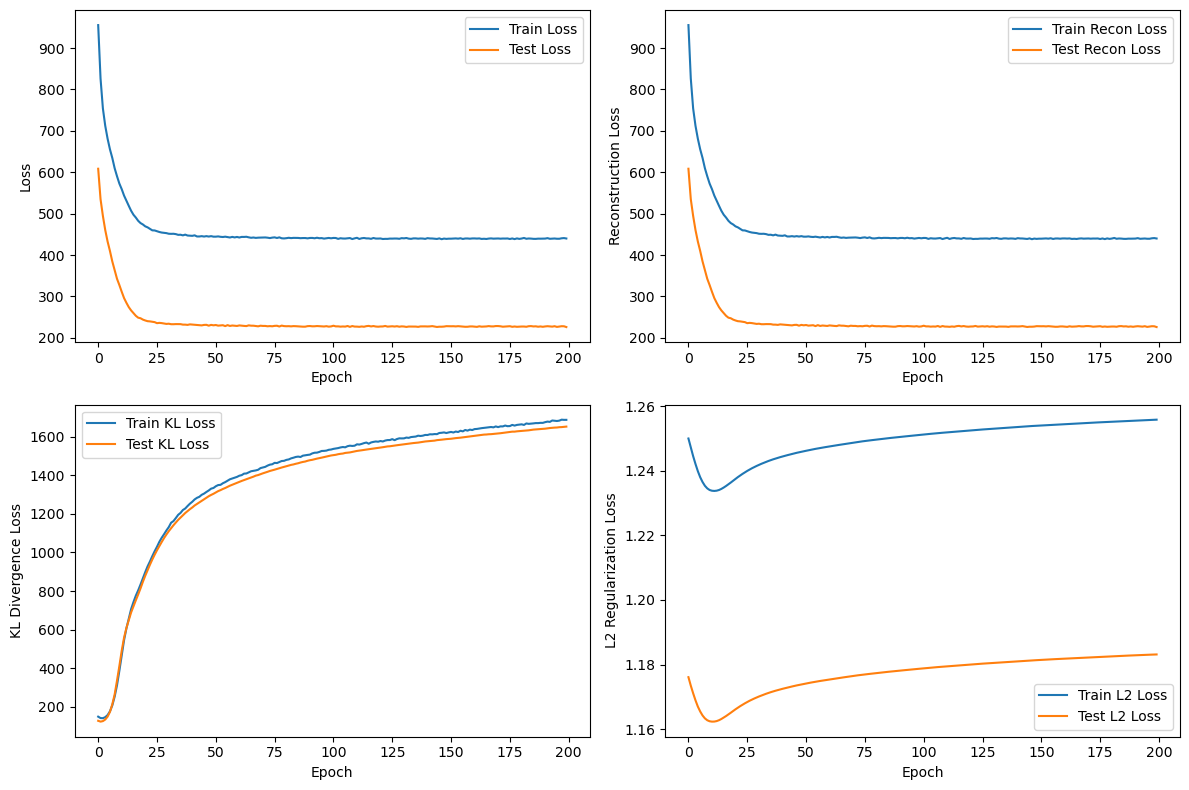

Epoch [210/1000], Train Loss: 439.9744, Train Recon Loss: 439.9732, Train KL Loss: 1695.0507, Train L2 Loss: 1.2561, Test Loss: 228.5696, Test Recon Loss: 228.5685, Test KL Loss: 1660.6609, Test L2 Loss: 1.1834
Epoch [220/1000], Train Loss: 438.9096, Train Recon Loss: 438.9084, Train KL Loss: 1705.4879, Train L2 Loss: 1.2563, Test Loss: 228.1120, Test Recon Loss: 228.1108, Test KL Loss: 1669.9634, Test L2 Loss: 1.1836
Epoch [230/1000], Train Loss: 438.7027, Train Recon Loss: 438.7015, Train KL Loss: 1717.3647, Train L2 Loss: 1.2566, Test Loss: 226.9391, Test Recon Loss: 226.9379, Test KL Loss: 1678.2029, Test L2 Loss: 1.1839
Epoch [240/1000], Train Loss: 439.7177, Train Recon Loss: 439.7164, Train KL Loss: 1716.7604, Train L2 Loss: 1.2569, Test Loss: 226.8872, Test Recon Loss: 226.8860, Test KL Loss: 1686.7081, Test L2 Loss: 1.1841
Epoch [250/1000], Train Loss: 439.6512, Train Recon Loss: 439.6499, Train KL Loss: 1728.3670, Train L2 Loss: 1.2571, Test Loss: 227.3035, Test Recon Loss: 2

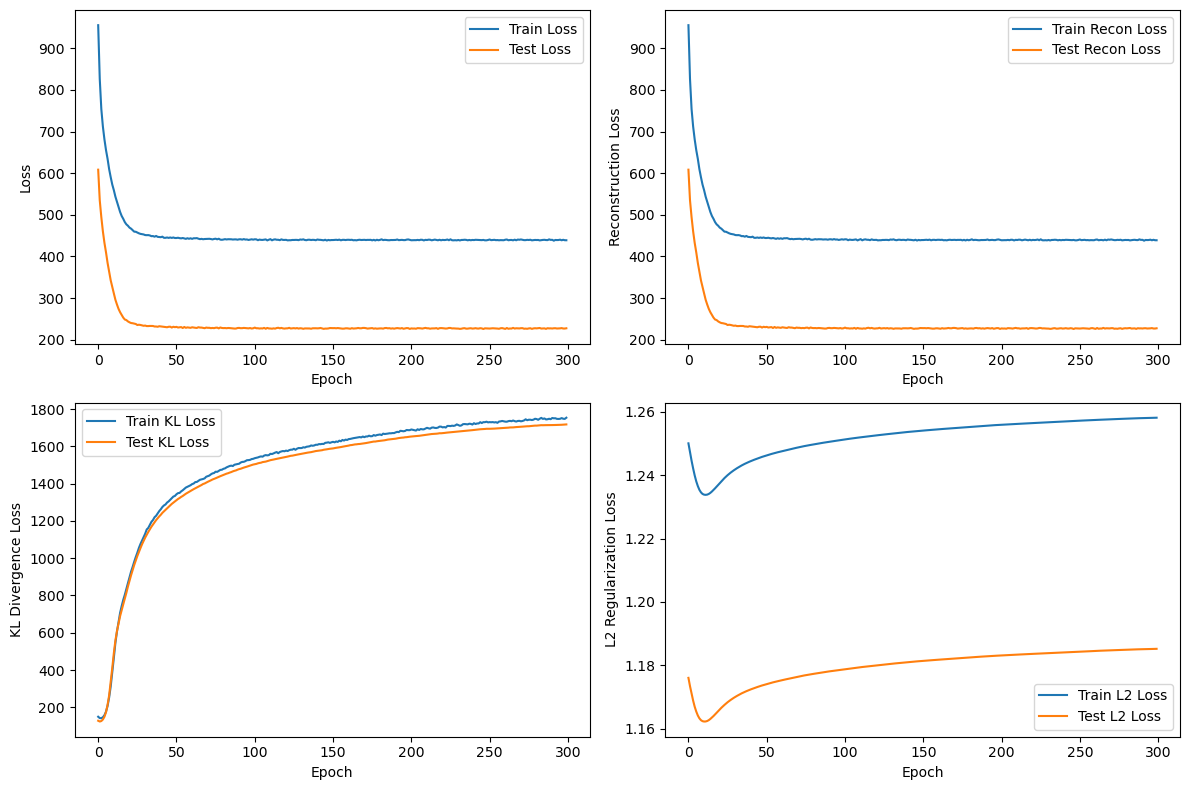

Epoch [310/1000], Train Loss: 439.5859, Train Recon Loss: 439.5846, Train KL Loss: 1756.2086, Train L2 Loss: 1.2582, Test Loss: 228.5981, Test Recon Loss: 228.5970, Test KL Loss: 1723.4102, Test L2 Loss: 1.1854
Epoch [320/1000], Train Loss: 439.2396, Train Recon Loss: 439.2384, Train KL Loss: 1763.6244, Train L2 Loss: 1.2584, Test Loss: 226.8716, Test Recon Loss: 226.8704, Test KL Loss: 1730.1573, Test L2 Loss: 1.1856
Epoch [330/1000], Train Loss: 439.5951, Train Recon Loss: 439.5939, Train KL Loss: 1770.2790, Train L2 Loss: 1.2585, Test Loss: 226.2574, Test Recon Loss: 226.2562, Test KL Loss: 1733.0676, Test L2 Loss: 1.1857
Epoch [340/1000], Train Loss: 438.3634, Train Recon Loss: 438.3622, Train KL Loss: 1773.9224, Train L2 Loss: 1.2587, Test Loss: 227.5804, Test Recon Loss: 227.5792, Test KL Loss: 1736.9671, Test L2 Loss: 1.1858
Epoch [350/1000], Train Loss: 438.9911, Train Recon Loss: 438.9899, Train KL Loss: 1773.1366, Train L2 Loss: 1.2588, Test Loss: 226.9079, Test Recon Loss: 2

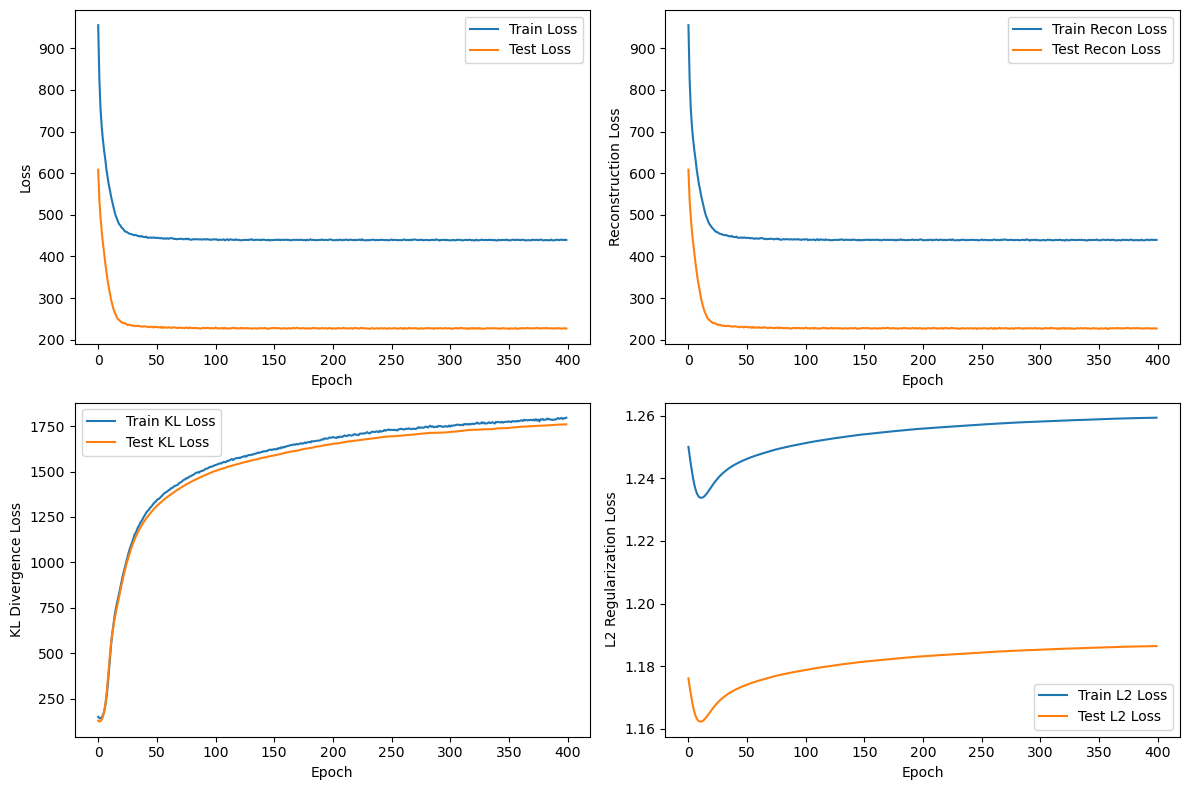

Epoch [410/1000], Train Loss: 439.0868, Train Recon Loss: 439.0856, Train KL Loss: 1795.1053, Train L2 Loss: 1.2594, Test Loss: 227.5057, Test Recon Loss: 227.5045, Test KL Loss: 1761.8491, Test L2 Loss: 1.1865
Epoch [420/1000], Train Loss: 439.5394, Train Recon Loss: 439.5381, Train KL Loss: 1804.4028, Train L2 Loss: 1.2595, Test Loss: 226.8706, Test Recon Loss: 226.8694, Test KL Loss: 1765.7995, Test L2 Loss: 1.1866
Epoch [430/1000], Train Loss: 440.0416, Train Recon Loss: 440.0404, Train KL Loss: 1806.3529, Train L2 Loss: 1.2596, Test Loss: 227.0932, Test Recon Loss: 227.0920, Test KL Loss: 1771.3754, Test L2 Loss: 1.1867
Epoch [440/1000], Train Loss: 439.6496, Train Recon Loss: 439.6483, Train KL Loss: 1804.8106, Train L2 Loss: 1.2597, Test Loss: 227.9691, Test Recon Loss: 227.9679, Test KL Loss: 1774.7419, Test L2 Loss: 1.1868
Epoch [450/1000], Train Loss: 440.4511, Train Recon Loss: 440.4498, Train KL Loss: 1806.1012, Train L2 Loss: 1.2598, Test Loss: 227.6504, Test Recon Loss: 2

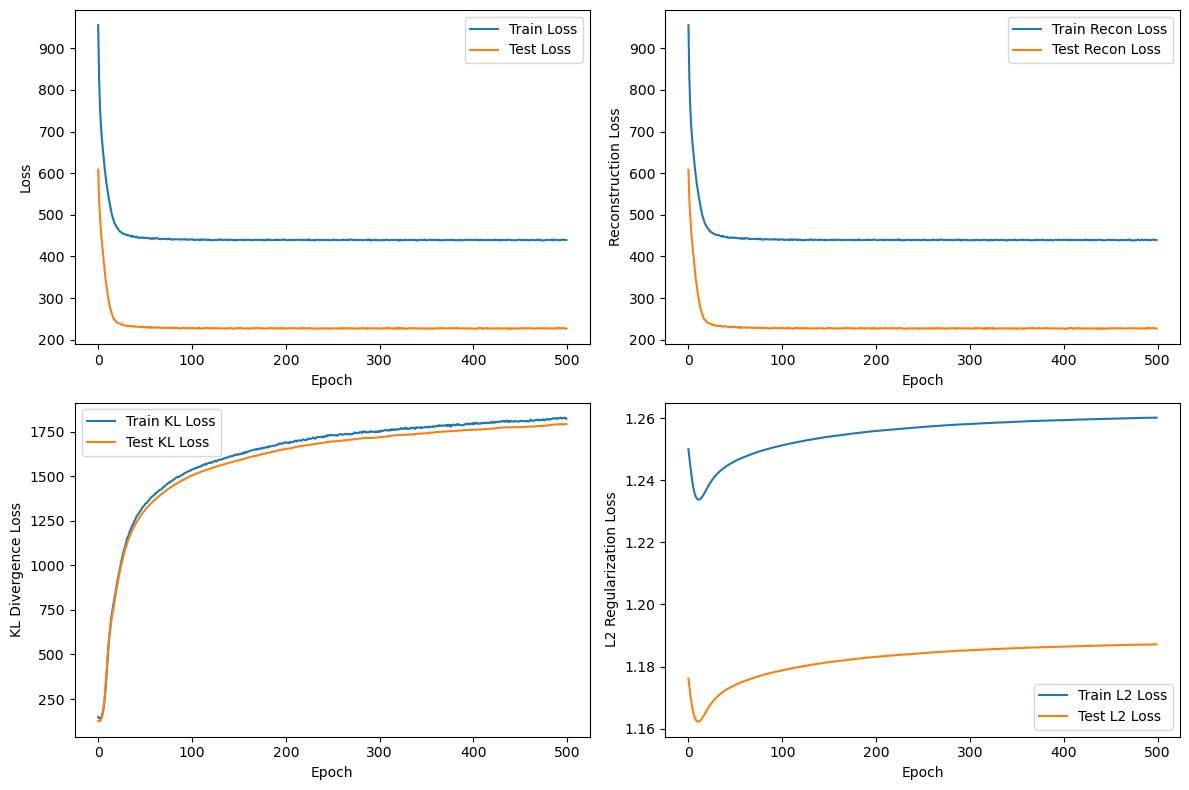

Epoch [510/1000], Train Loss: 439.0479, Train Recon Loss: 439.0467, Train KL Loss: 1827.6758, Train L2 Loss: 1.2602, Test Loss: 228.3901, Test Recon Loss: 228.3889, Test KL Loss: 1792.8977, Test L2 Loss: 1.1872
Epoch [520/1000], Train Loss: 439.4226, Train Recon Loss: 439.4213, Train KL Loss: 1826.1619, Train L2 Loss: 1.2602, Test Loss: 228.0556, Test Recon Loss: 228.0544, Test KL Loss: 1796.1887, Test L2 Loss: 1.1873
Epoch [530/1000], Train Loss: 438.7614, Train Recon Loss: 438.7601, Train KL Loss: 1829.9414, Train L2 Loss: 1.2603, Test Loss: 227.6174, Test Recon Loss: 227.6162, Test KL Loss: 1797.6690, Test L2 Loss: 1.1873
Epoch [540/1000], Train Loss: 439.6035, Train Recon Loss: 439.6022, Train KL Loss: 1834.7946, Train L2 Loss: 1.2604, Test Loss: 227.1301, Test Recon Loss: 227.1289, Test KL Loss: 1801.4268, Test L2 Loss: 1.1874
Epoch [550/1000], Train Loss: 439.7071, Train Recon Loss: 439.7058, Train KL Loss: 1843.8204, Train L2 Loss: 1.2604, Test Loss: 228.4236, Test Recon Loss: 2

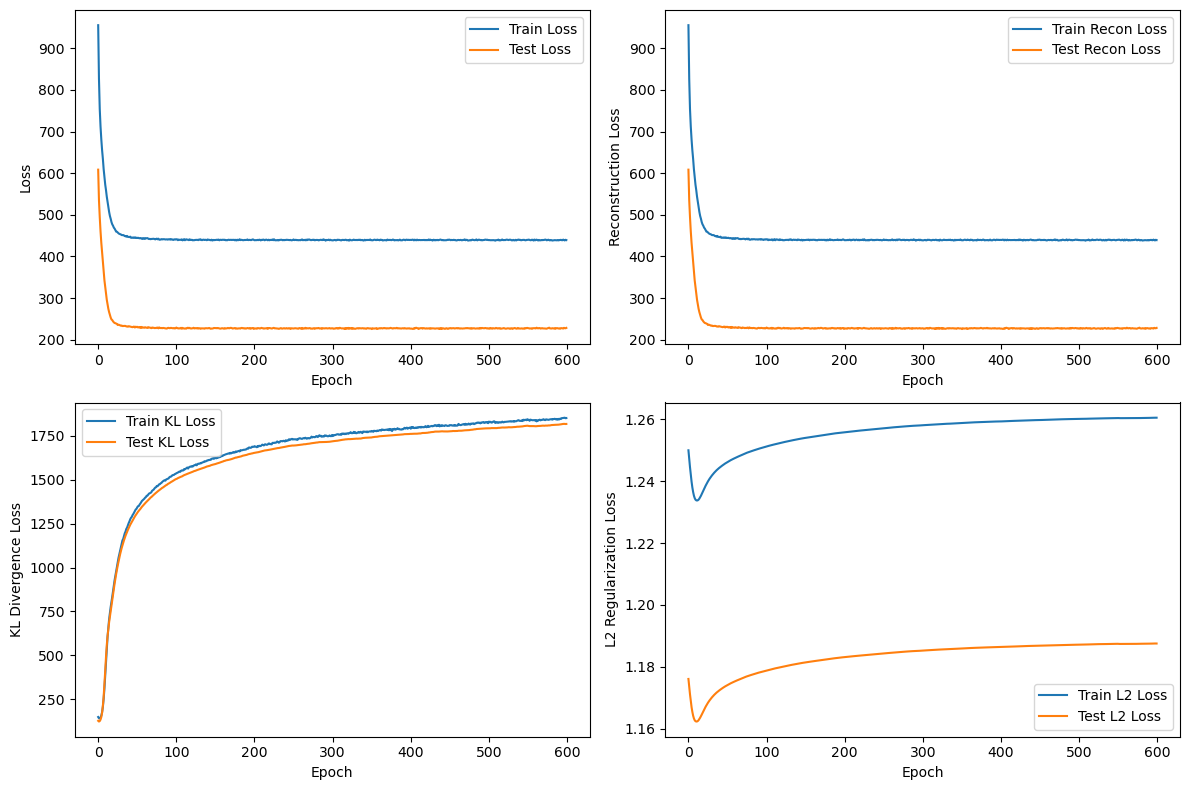

Epoch [610/1000], Train Loss: 439.1552, Train Recon Loss: 439.1540, Train KL Loss: 1848.0556, Train L2 Loss: 1.2605, Test Loss: 226.7929, Test Recon Loss: 226.7917, Test KL Loss: 1819.0121, Test L2 Loss: 1.1875
Epoch [620/1000], Train Loss: 439.7782, Train Recon Loss: 439.7769, Train KL Loss: 1855.4838, Train L2 Loss: 1.2605, Test Loss: 226.8537, Test Recon Loss: 226.8526, Test KL Loss: 1821.0023, Test L2 Loss: 1.1876
Epoch [630/1000], Train Loss: 439.3429, Train Recon Loss: 439.3416, Train KL Loss: 1855.4289, Train L2 Loss: 1.2605, Test Loss: 226.2974, Test Recon Loss: 226.2962, Test KL Loss: 1820.9241, Test L2 Loss: 1.1875
Epoch [640/1000], Train Loss: 439.2754, Train Recon Loss: 439.2742, Train KL Loss: 1854.5572, Train L2 Loss: 1.2604, Test Loss: 228.4455, Test Recon Loss: 228.4443, Test KL Loss: 1822.5970, Test L2 Loss: 1.1875
Epoch [650/1000], Train Loss: 439.5640, Train Recon Loss: 439.5628, Train KL Loss: 1858.9094, Train L2 Loss: 1.2604, Test Loss: 229.0857, Test Recon Loss: 2

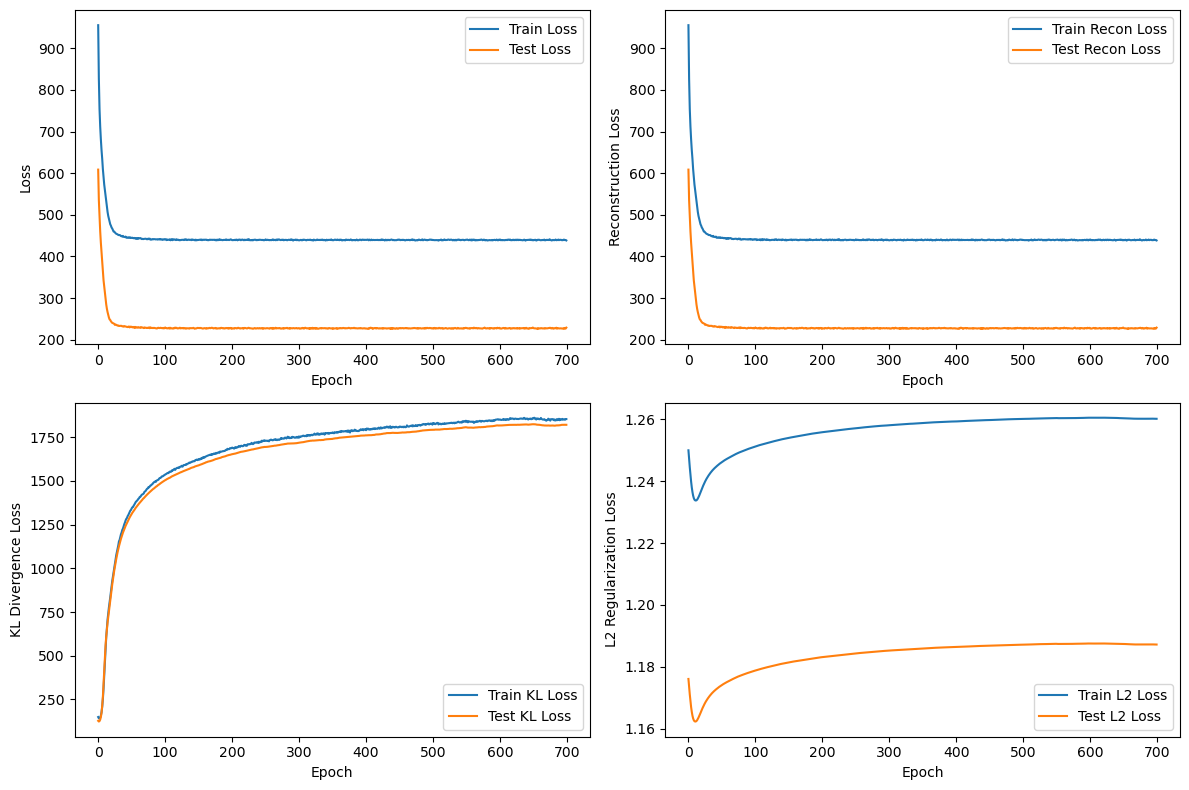

Epoch [710/1000], Train Loss: 439.7963, Train Recon Loss: 439.7950, Train KL Loss: 1856.5597, Train L2 Loss: 1.2601, Test Loss: 226.4955, Test Recon Loss: 226.4943, Test KL Loss: 1823.7403, Test L2 Loss: 1.1872
Epoch [720/1000], Train Loss: 440.0913, Train Recon Loss: 440.0900, Train KL Loss: 1860.9077, Train L2 Loss: 1.2600, Test Loss: 227.3623, Test Recon Loss: 227.3612, Test KL Loss: 1824.5681, Test L2 Loss: 1.1871
Epoch [730/1000], Train Loss: 439.7083, Train Recon Loss: 439.7071, Train KL Loss: 1861.0163, Train L2 Loss: 1.2600, Test Loss: 226.4748, Test Recon Loss: 226.4736, Test KL Loss: 1829.1264, Test L2 Loss: 1.1870
Epoch [740/1000], Train Loss: 438.9911, Train Recon Loss: 438.9899, Train KL Loss: 1858.7003, Train L2 Loss: 1.2599, Test Loss: 227.3616, Test Recon Loss: 227.3604, Test KL Loss: 1829.9088, Test L2 Loss: 1.1870
Epoch [750/1000], Train Loss: 439.0244, Train Recon Loss: 439.0231, Train KL Loss: 1868.8848, Train L2 Loss: 1.2599, Test Loss: 227.0959, Test Recon Loss: 2

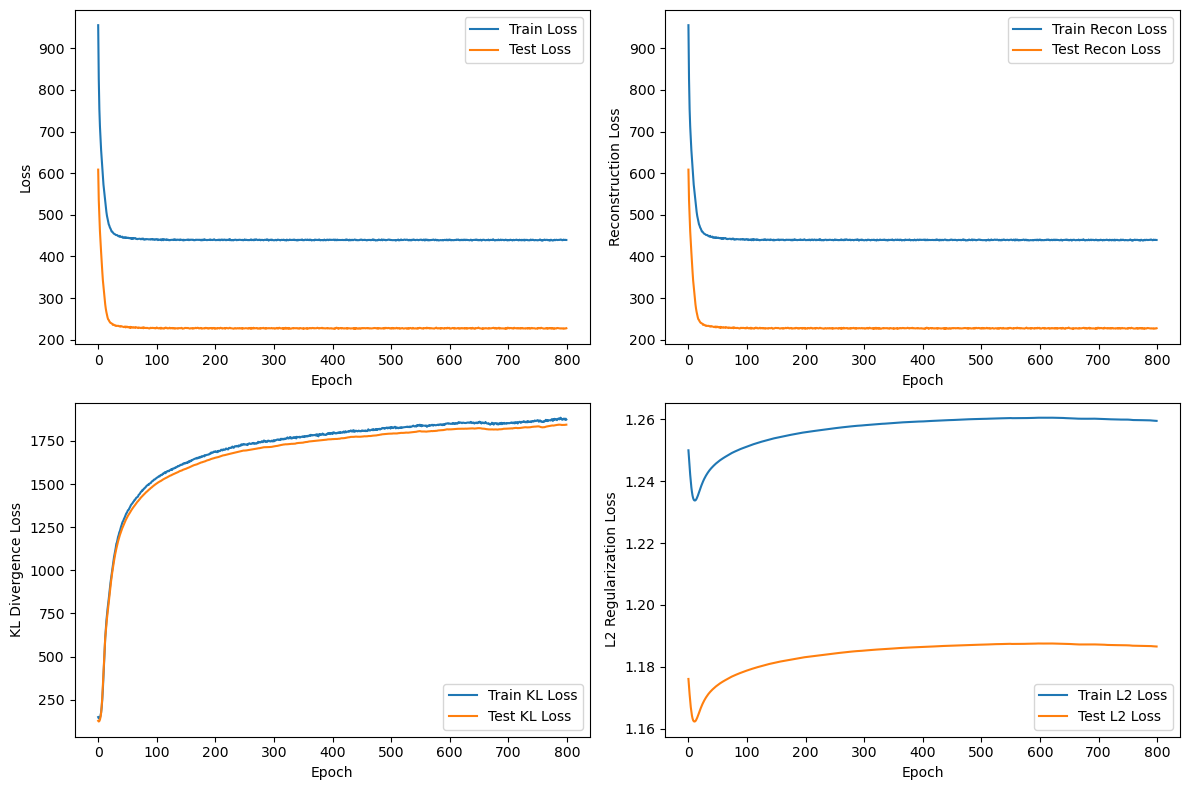

Epoch [810/1000], Train Loss: 438.8991, Train Recon Loss: 438.8978, Train KL Loss: 1880.7817, Train L2 Loss: 1.2594, Test Loss: 227.4737, Test Recon Loss: 227.4725, Test KL Loss: 1845.3989, Test L2 Loss: 1.1865
Epoch [820/1000], Train Loss: 437.9679, Train Recon Loss: 437.9666, Train KL Loss: 1879.0190, Train L2 Loss: 1.2593, Test Loss: 226.9352, Test Recon Loss: 226.9340, Test KL Loss: 1848.1477, Test L2 Loss: 1.1864
Epoch [830/1000], Train Loss: 438.8037, Train Recon Loss: 438.8025, Train KL Loss: 1883.0716, Train L2 Loss: 1.2592, Test Loss: 226.5384, Test Recon Loss: 226.5372, Test KL Loss: 1851.0706, Test L2 Loss: 1.1863
Epoch [840/1000], Train Loss: 439.4851, Train Recon Loss: 439.4838, Train KL Loss: 1886.5563, Train L2 Loss: 1.2590, Test Loss: 227.9450, Test Recon Loss: 227.9438, Test KL Loss: 1850.1896, Test L2 Loss: 1.1861
Epoch [850/1000], Train Loss: 438.2991, Train Recon Loss: 438.2978, Train KL Loss: 1891.6480, Train L2 Loss: 1.2589, Test Loss: 226.8505, Test Recon Loss: 2

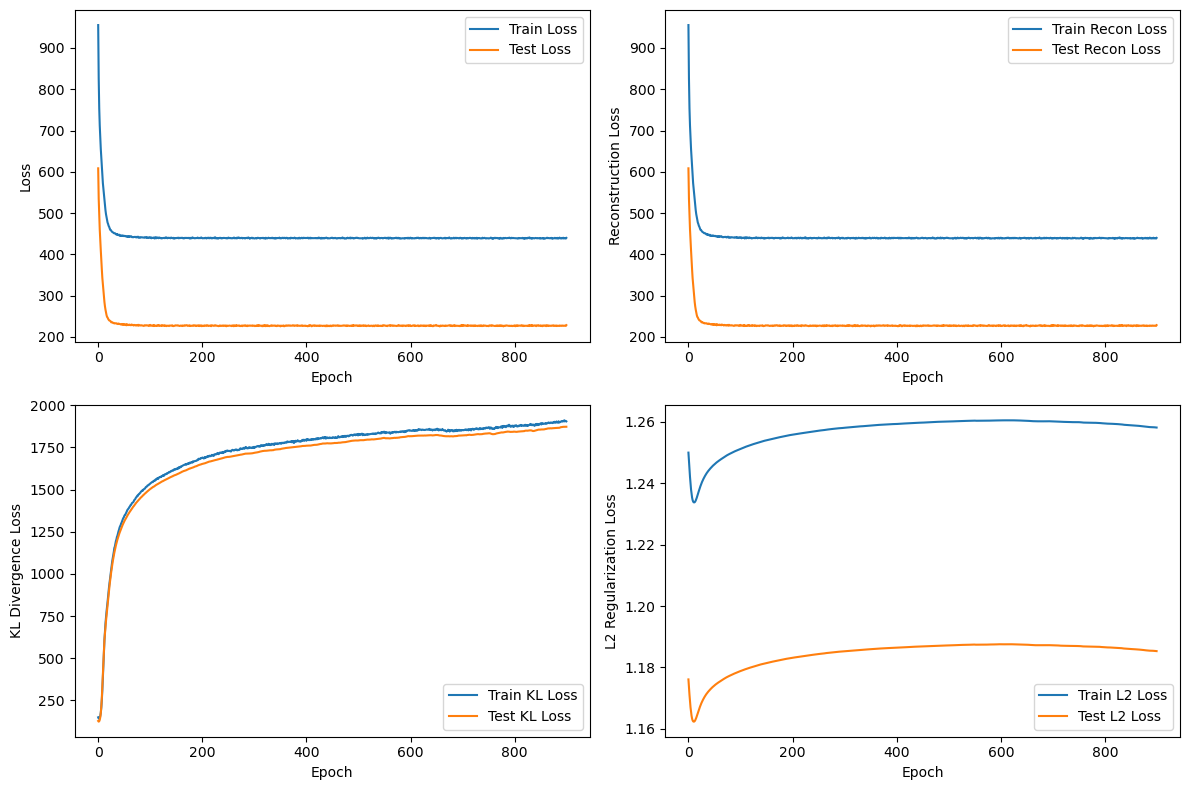

Epoch [910/1000], Train Loss: 439.2586, Train Recon Loss: 439.2573, Train KL Loss: 1911.7373, Train L2 Loss: 1.2579, Test Loss: 227.1654, Test Recon Loss: 227.1642, Test KL Loss: 1873.4858, Test L2 Loss: 1.1851
Epoch [920/1000], Train Loss: 439.3197, Train Recon Loss: 439.3185, Train KL Loss: 1906.7610, Train L2 Loss: 1.2577, Test Loss: 227.5730, Test Recon Loss: 227.5718, Test KL Loss: 1872.1539, Test L2 Loss: 1.1849
Epoch [930/1000], Train Loss: 439.0076, Train Recon Loss: 439.0063, Train KL Loss: 1908.6906, Train L2 Loss: 1.2575, Test Loss: 227.3649, Test Recon Loss: 227.3637, Test KL Loss: 1874.7745, Test L2 Loss: 1.1847
Epoch [940/1000], Train Loss: 437.8915, Train Recon Loss: 437.8902, Train KL Loss: 1910.2301, Train L2 Loss: 1.2572, Test Loss: 228.0083, Test Recon Loss: 228.0071, Test KL Loss: 1878.0229, Test L2 Loss: 1.1844
Epoch [950/1000], Train Loss: 438.7836, Train Recon Loss: 438.7823, Train KL Loss: 1915.2271, Train L2 Loss: 1.2570, Test Loss: 226.8777, Test Recon Loss: 2

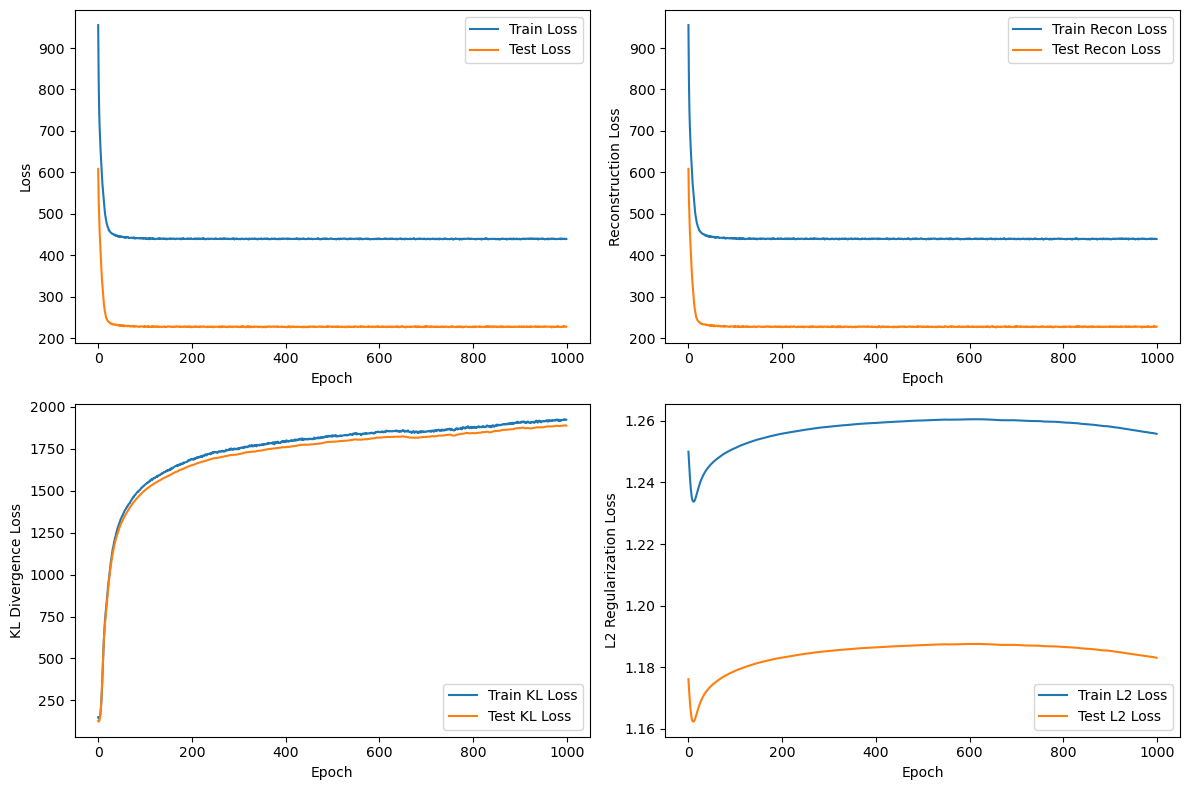

In [17]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
seq_length = 21
batch_size = 256
learning_rate = 0.001
epochs = 1000
beta_end = 0
lambda_reg = 0.001
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500
decay_rate_beta = 0.96
decay_steps_beta = 20

train_dataset, test_dataset = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

model.train()
train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_kl_losses = []
test_kl_losses = []
train_l2_losses = []
test_l2_losses = []

torch.autograd.set_detect_anomaly(True)
for epoch in trange(1, epochs+1):
    beta_decay_term = beta_end * (decay_rate_beta ** (epoch // decay_steps_beta))
    beta = beta_end - beta_decay_term

    train_loss, train_recon_loss, train_kl_loss, train_l2_loss = train(model, train_loader, optimizer, beta, lambda_reg, device)
    test_loss, test_recon_loss, test_kl_loss, test_l2_loss = test(model, test_loader, beta, lambda_reg, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    train_l2_losses.append(train_l2_loss)
    test_l2_losses.append(test_l2_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Train L2 Loss: {train_l2_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}, "
              f"Test L2 Loss: {test_l2_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_l2_losses, label='Train L2 Loss')
        plt.plot(test_l2_losses, label='Test L2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Regularization Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Further training

In [106]:
end_epoch = 500
# model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
# model.load_state_dict(torch.load('model_checkpoints/model_epoch_500.pth'))

model.train()
for epoch in trange(500, epochs+1):
    if epoch < beta_threshold:
        beta = beta_start
    else:
        beta = beta_start + (beta_end - beta_start) * (epoch - beta_threshold) / (epochs - beta_threshold)

    train_loss, train_recon_loss, train_kl_loss, train_l2_loss = train(model, train_loader, optimizer, beta, lambda_reg, device)
    test_loss, test_recon_loss, test_kl_loss, test_l2_loss = test(model, test_loader, beta, lambda_reg, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    train_l2_losses.append(train_l2_loss)
    test_l2_losses.append(test_l2_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Train L2 Loss: {train_l2_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}, "
              f"Test L2 Loss: {test_l2_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_l2_losses, label='Train L2 Loss')
        plt.plot(test_l2_losses, label='Test L2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Regularization Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Learning rate decay
    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

FileNotFoundError: [Errno 2] No such file or directory: 'model_checkpoints/model_epoch_500.pth'

# Final model

In [ ]:
model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_100.pth'))

<All keys matched successfully>

# Testing randomness

In [11]:
x = torch.rand(1, 21, 13).to(device)

with torch.no_grad():
    model.eval()
    z_list, r_list, mu_z_list, log_sigma_z_list = model(x)

print(f"Input sequence (x) of {x.shape}:")
print(x[0][0])
print(f"Generated r_list of {r_list.shape}:")
print(r_list[0][0])

Input sequence (x) of torch.Size([1, 21, 13]):
tensor([0.5227, 0.1760, 0.7278, 0.2665, 0.2636, 0.5922, 0.7392, 0.5952, 0.6095,
        0.4738, 0.5165, 0.1674, 0.2923])
Generated r_list of torch.Size([1, 21, 13]):
tensor([-0.1556, -0.2810,  1.3183,  1.0191, -0.1251, -0.8033, -0.0714,  0.7254,
         0.3134,  0.3835,  0.0742, -0.4567,  1.1597])


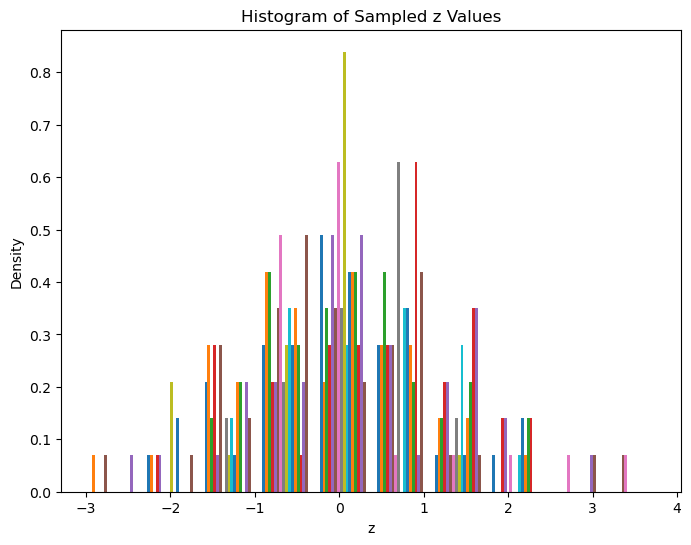

In [12]:
z_samples = torch.zeros_like(mu_z_list)
for t in range(mu_z_list.size(1)):
    z_samples[:, t, :] = model.encoder.reparametrization_trick(mu_z_list[:, t, :], log_sigma_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show()

# VaR Forecasting

In [ ]:
portfolio_weights = np.random.rand(data.shape[1])
portfolio_weights /= np.sum(portfolio_weights)
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)
train_dataset, test_dataset = preprocess_data(data, seq_length)

In [ ]:
def generate_var_forecast(model, sequence, weights, num_samples=1000, alpha=0.01, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        seq_len = sequence.size(0)
        sequence = sequence.unsqueeze(0).to(device)

        z_prev = torch.zeros(1, 1, model.latent_dim).to(device)

        for t in range(seq_len):
            x_t = sequence[:, t, :].unsqueeze(1)
            mu_z, logvar_z = model.encoder(x_t, z_prev)
            z_t = model.reparameterize(mu_z, logvar_z)
            z_prev = z_t.unsqueeze(1)

        z_prev = z_t

        portfolio_returns = []
        for _ in range(num_samples):
            prior_mu, prior_logvar = model.prior_network(z_prev.unsqueeze(1))
            z_next = model.reparameterize(prior_mu, prior_logvar)
            x_forecast = model.decoder(z_next.unsqueeze(1), 1)
            portfolio_return = torch.matmul(x_forecast.squeeze(1), weights).item()
            portfolio_returns.append(portfolio_return)

        var_forecast = np.percentile(portfolio_returns, alpha * 100)

    return var_forecast

var_forecast_one = generate_var_forecast(model, test_dataset[0][0], portfolio_weights, device=device)
print(var_forecast_one)

-1.747743046283722


In [ ]:
torch.matmul((test_dataset[1][0]), portfolio_weights)[-1]

tensor(-1.6907)

In [ ]:
def var_rolling_forecast(model, test_dataset, weights, seq_length=21, num_samples=1000, alpha=0.05, device=torch.device('cpu')):
    var_forecasts = []

    for i in trange(len(test_dataset) - seq_length + 1):
        sequence = test_dataset[i:i+seq_length]
        sequence = torch.cat([item[0] for item in sequence], dim=0)
        var_forecast = generate_var_forecast(model, sequence, weights, num_samples, alpha, device)
        var_forecasts.append(var_forecast)

    return np.array(var_forecasts)

var_forecasts = var_rolling_forecast(model, test_dataset, portfolio_weights)

  0%|          | 0/740 [00:00<?, ?it/s]

In [ ]:
var_forecasts[:40]

array([-1.27834028, -1.24926998, -1.36016433, -1.3145119 , -1.2895914 ,
       -1.27995487, -1.21145042, -1.27022794, -1.2366299 , -1.17751459,
       -1.22094059, -1.30538957, -1.44598402, -1.27101033, -1.27125781,
       -1.31346399, -1.33653789, -1.27390947, -1.29271837, -1.20504415,
       -1.34362484, -1.21480362, -1.15063279, -1.3279394 , -1.24507825,
       -1.30716277, -1.21731719, -1.43617905, -1.21852368, -1.08744431,
       -1.24061098, -1.28061879, -1.36781247, -1.32512868, -1.22397168,
       -1.27859761, -1.30122334, -1.19336143, -1.27613745, -1.3413529 ])

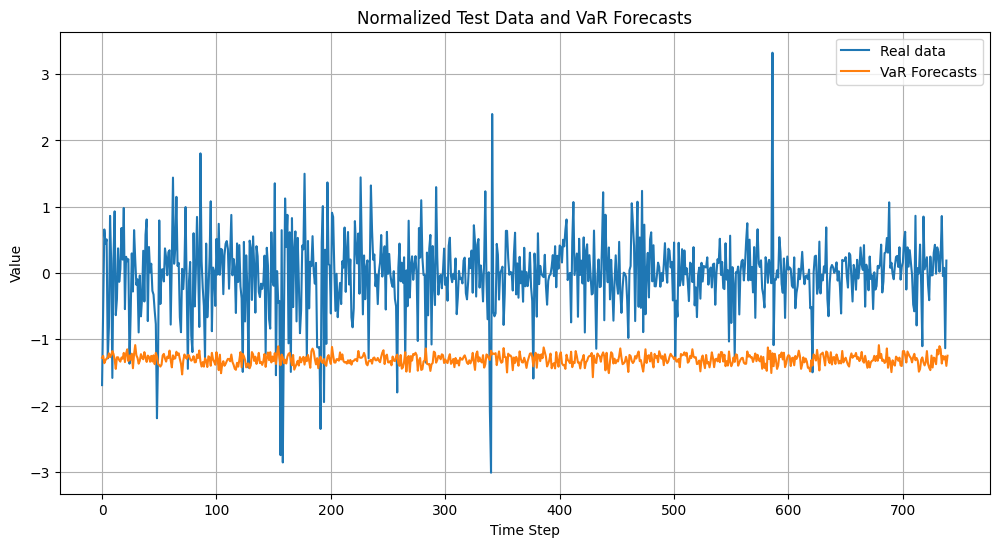

In [ ]:
def extract_normalized_test_data(test_dataset):
    test_data = []
    for sequence in test_dataset:
        test_data.append(sequence[0][0][:].numpy())
    return np.array(test_data)

normalized_test_data = extract_normalized_test_data(test_dataset)
portfolio = torch.tensor(normalized_test_data, dtype=torch.float32, device=device)
portfolio = torch.matmul(portfolio, portfolio_weights)

plt.figure(figsize=(12, 6))
plt.plot(portfolio[seq_length:], label='Real data')
# plt.plot(portfolio[seq_length - 1:][:40], label='One step back data')
plt.plot(var_forecasts, label='VaR Forecasts')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Normalized Test Data and VaR Forecasts')
plt.legend()
plt.grid(True)
plt.show()